In [1]:
!pip install openpyxl
!pip install pmdarima

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
  Using cached pmdarima-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.8 MB)


In [2]:
import numpy as np
import pandas as pd
import calendar
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from pmdarima.arima import auto_arima

## Import Data

In [3]:
#2018-2022 Data Sheets' Naming Format:  Ridership_yyyymm.xlsx
#2010-2017 Data Sheets' Naming Format: Ridership_Aprilyyyy.xlsx

In [4]:
pd.read_excel("Data/ridership_2010/Ridership_January2010.xlsx", header=1, index_col=0).head(5)

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55
RM,4.894737,107.526316,108.157895,89.684211,345.526316,79.894737,142.473684,134.210526,182.263158,35.631579,...,NaN,Eastbay,72413.894737,NaN,SF CBD,204901.842105,0.642676,NaN,NaN,NaN
EN,128.631579,10.842105,101.105263,83.157895,787.263158,123.157895,264.473684,419.789474,610.315789,88.789474,...,NaN,Westbay,90407.684211,NaN,non-CBD,107559.789474,0.337362,NaN,NaN,NaN
EP,105.789474,82.736842,4.947368,58.000000,586.684211,69.842105,120.789474,225.000000,269.368421,66.684211,...,NaN,Transbay,156004.421053,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NB,76.631579,65.631579,60.684211,7.842105,187.421053,53.000000,86.210526,206.315789,242.263158,57.842105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BK,381.842105,800.421053,580.526316,204.473684,14.105263,324.684211,428.000000,427.526316,503.368421,206.210526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
pd.read_excel("Data/ridership_2018/Ridership_201801.xlsx", header=1, index_col=0).head(5)

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,NC,WP,SS,SB,SO,MB,WD,OA,WS,Exits
RM,12.761905,108.619048,81.904762,64.952381,365.619048,101.571429,138.047619,149.190476,180.095238,37.571429,...,2.190476,35.000000,12.190476,18.904762,58.714286,26.666667,7.619048,12.333333,7.476190,3934.952381
EN,131.952381,20.333333,91.285714,95.761905,825.857143,139.380952,261.619048,471.476190,562.285714,93.714286,...,5.571429,26.571429,34.095238,42.619048,113.619048,71.190476,13.285714,30.904762,26.476190,8247.380952
EP,86.428571,81.380952,12.857143,46.904762,659.190476,83.047619,133.761905,298.000000,336.333333,56.285714,...,3.666667,11.190476,10.285714,11.142857,60.333333,31.809524,7.476190,24.714286,11.000000,4702.190476
NB,72.380952,87.142857,51.047619,15.619048,199.619048,61.333333,91.190476,285.190476,249.333333,46.333333,...,3.285714,16.238095,7.857143,9.809524,91.380952,35.809524,8.000000,30.761905,16.571429,4396.142857
BK,405.619048,897.095238,667.809524,208.000000,35.619048,360.761905,361.904762,562.285714,528.428571,226.761905,...,49.142857,113.047619,34.428571,39.238095,179.904762,139.095238,48.523810,73.523810,78.380952,11122.666667


In [6]:
def monthly_weekday_counts(entry_station, exit_station, start_year, end_year):
    monthly_weekday_counts = []
    monthly_weekday_plot_label = []

    for year in np.arange(start_year, end_year+1, 1):
        dir_path = f'Data/ridership_{year}/'
        if year <= 2017:
            for month in np.arange(1, 13, 1):
                two_digits_format_month = '{:02d}'.format(month)
                file_name = f'Ridership_{calendar.month_name[month]}{year}.xlsx'
                file_path = os.path.join(dir_path, file_name)
                monthly_weekday_counts.append(pd.read_excel(file_path, header=1, index_col=0).loc[exit_station, entry_station])
                monthly_weekday_plot_label.append(f'{year}-{two_digits_format_month}')
        else:
            for month in np.arange(1, 13, 1):
                two_digits_format_month = '{:02d}'.format(month)
                file_name = f'Ridership_{year}{two_digits_format_month}.xlsx'
                file_path = os.path.join(dir_path, file_name)
                monthly_weekday_counts.append(pd.read_excel(file_path, header=1, index_col=0).loc[exit_station, entry_station])
                monthly_weekday_plot_label.append(f'{year}-{two_digits_format_month}')
                
    return monthly_weekday_counts, monthly_weekday_plot_label

In [7]:
#Berkeley_Embarcadero_2010_2014, label = monthly_weekday_counts("BK", "EM", 2010, 2014)

In [8]:
#plot
#fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(label, Berkeley_Embarcadero_2010_2014)
#ax.set_xticks(label)
#ax.set_xticklabels(label, rotation=90);

## Analysis

For this section of the analysis, the focus will be on analyzing the ridership from Downtown Berkeley station (entry station) to Embarcadero station (exit station) pre- and post-pandemic to infer the impact of Covid-19 on people's choice of transportation modes. The reason for selecting these two stations is that, firstly, students constitute the majority of Downtown Berkeley station riders. Because they typically don't own cars, the impact could be much more significant. Secondly, Embarcadero is one of the busiest stations according to BART's website (bart.gov). With the growing popularity of remote working and studying during the pandemic, it is highly likely that the ridership for these two stations has changed drastically. Hypothetically, it may take a long period of time for the ridership to recover back to pre-pandemic levels.

*pre-pandemic: before 2020, post-pandemic: after 2020

### Pre-Pandemic Ridership

In [9]:
Berkeley_Embarcadero_2010_2019, label = monthly_weekday_counts("BK", "EM", 2010, 2019)

In [10]:
ts_2010_2019 = pd.DataFrame(data={'Weekday Counts': Berkeley_Embarcadero_2010_2019}, 
                            index=pd.to_datetime(label, format='%Y-%m'))

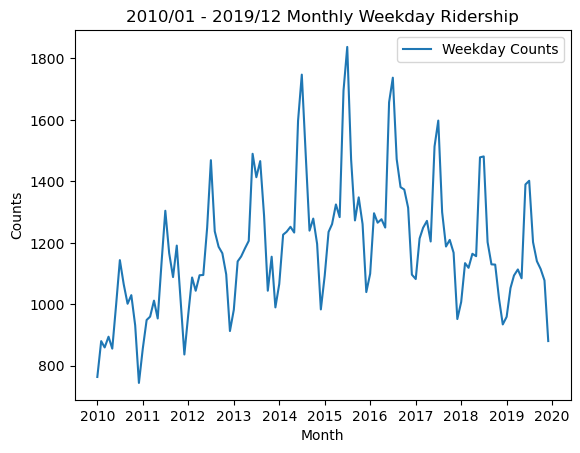

In [11]:
sns.lineplot(ts_2010_2019)
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("2010/01 - 2019/12 Monthly Weekday Ridership");
plt.savefig("figures/Berkeley_Embarcadero_2010_2019_Ridership.png")

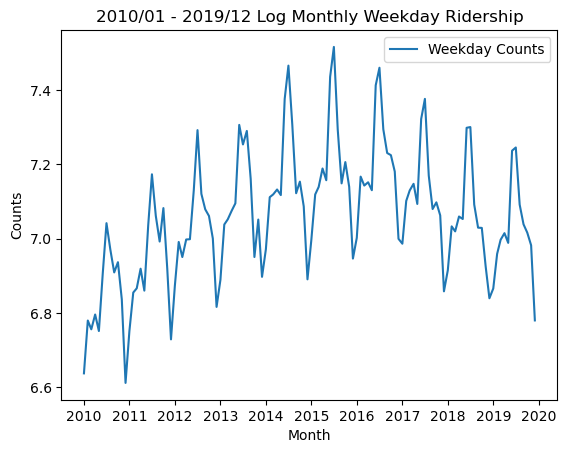

In [12]:
logts_2010_2019 = np.log(ts_2010_2019)
sns.lineplot(logts_2010_2019)
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("2010/01 - 2019/12 Log Monthly Weekday Ridership");
plt.savefig("figures/Berkeley_Embarcadero_2010_2019_Log_Ridership.png")

Based on the plots above, there appears to be an annual seasonality with the peak around summer and the trough around winter. In general, there is an increasing trend observed throughout 2010-2015, but it gradually declines afterwards. The variance of ridership over time has been steady, although the variances for the years 2014-2016 are larger than those of other years. To standardize the variance of the data, a Log Transformation has been applied.

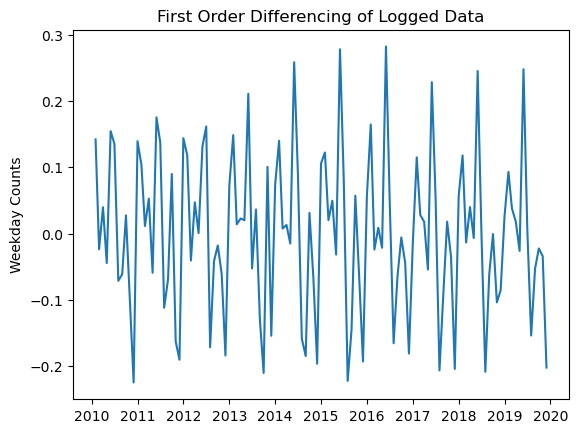

In [13]:
first_order_dif = logts_2010_2019['Weekday Counts'].diff(periods=1)
sns.lineplot(first_order_dif)
plt.title("First Order Differencing of Logged Data");

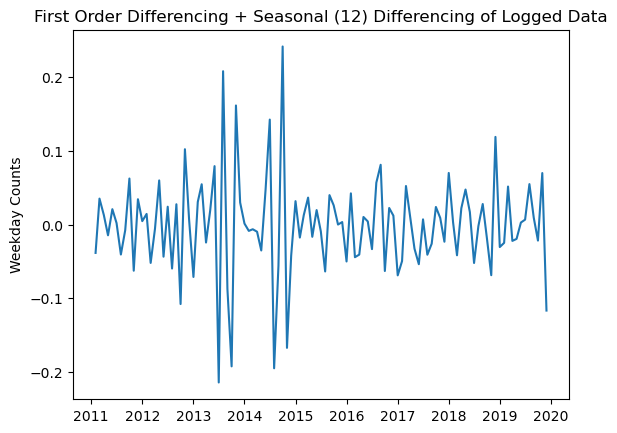

In [14]:
seasonal_order_dif = first_order_dif.diff(periods=12)
sns.lineplot(seasonal_order_dif)
plt.title("First Order Differencing + Seasonal (12) Differencing of Logged Data");

In [15]:
#dropping the nan values resulted from differencing
seasonal_order_dif_dropna = seasonal_order_dif.dropna()

In [16]:
ad_fuller_result = adfuller(seasonal_order_dif_dropna)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.3309425227916325
p-value: 0.00039248581825599885


After taking the first order difference, the plot shows that the data is non-stationary with a strong seasonality at the indies of multiples of 12. To minimize the effect of seasonality, another lag difference of 12 is taken. The resulting plot gives a much better result in terms of stationarity. Moreover, the p-value of the adfuller test is below 0.05, allowing us to reject the null and conclude that the differenced data is stationary. Below is the sample ACF and PACF plot of diff(diff(lag = 1), lag = 12): 

/srv/conda/envs/notebook/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


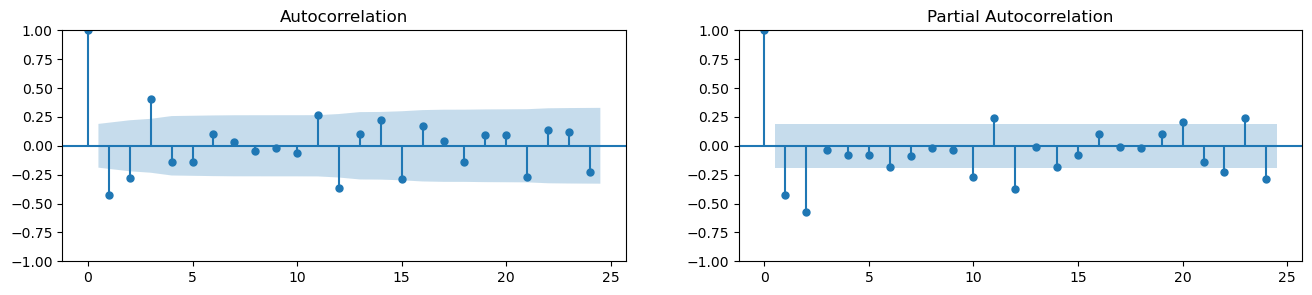

In [17]:
#plot acf and pacf
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(seasonal_order_dif_dropna.tolist(), lags=24, ax=axes[0], alpha=0.05);
plot_pacf(seasonal_order_dif_dropna.tolist(), lags=24, ax=axes[1], alpha=0.05);

The ACF and PACF plots show no significant cutoff after lag=12, indicating the differencing in the previous stages is chosen correctly. The data set is then split into training and testing, and a parameter search is performed on the training set to determine the best arima model. 

In [18]:
#training and testing sets split (train:100, test:20) 
train = logts_2010_2019[:100]
test = logts_2010_2019[100:]

In [19]:
#parameter search ; Best model:  ARIMA(2,1,0)(0,1,1)[12]
Arima_model=auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3,
                       start_P=0, start_Q=0, max_P=1, max_Q=1, m=12,
                       seasonal=True, trace=True, d=1, D=1, error_action='warn',
                       suppress_warnings=True, random_state = 20, n_fits=10)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-250.234, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-211.494, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-232.581, Time=0.77 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-258.744, Time=1.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-252.131, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-258.914, Time=1.54 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-254.759, Time=1.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-256.944, Time=2.69 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=-256.992, Time=2.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-262.615, Time=4.00 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-262.513, Time=2.70 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-258.991, Time=2.73 sec
 ARIMA(1,1,2)(0,1,0)[12]     

In [20]:
prediction = Arima_model.predict(n_periods=20, index=test.index)

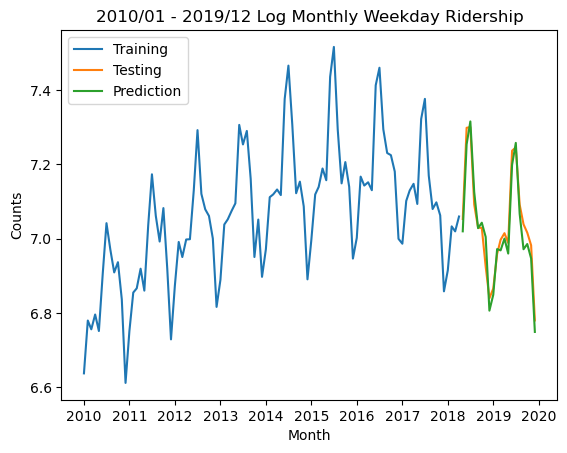

In [26]:
plt.plot(train, label="Training")
plt.plot(test, label="Testing")
plt.plot(prediction, label="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("2010/01 - 2019/12 Log Monthly Weekday Ridership")
plt.savefig("figures/Berkeley_Embarcadero_2010_2019_Modeling.png")
plt.show()

### Post-Pandemic Ridership

The extent of influence is calculated by computing the absolute difference between the ridership predicted by the pre-pandemic model and the actual ridership observed in 2021-2022. Since the output value of the pre-pandemic model is logged, the result must be exponentialized for comparison to be feasible.

In [22]:
#import 2021-2022 data
Berkeley_Embarcadero_2021_2022, label2 = monthly_weekday_counts("BK", "EM", 2021, 2022)
ts_2021_2022 = pd.DataFrame(data={'Weekday Counts': Berkeley_Embarcadero_2021_2022}, 
                            index=pd.to_datetime(label2, format='%Y-%m'))

In [23]:
prediction_2021_2022 = np.exp(Arima_model.predict(n_periods=56)[32:])

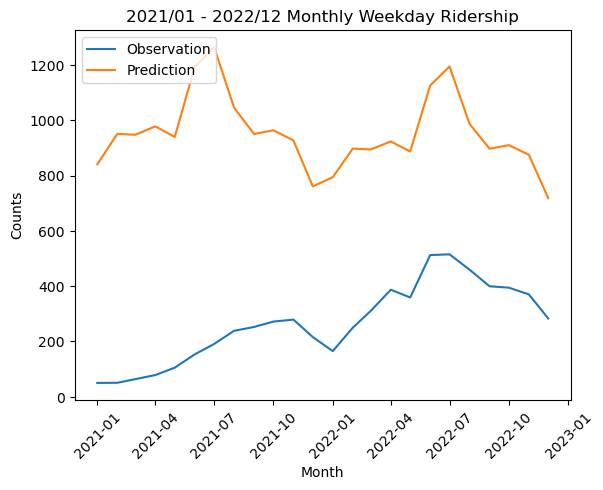

In [27]:
plt.plot(ts_2021_2022, label="Observation")
plt.plot(prediction_2021_2022, label="Prediction")
plt.legend(loc="upper left")
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("2021/01 - 2022/12 Monthly Weekday Ridership")
plt.savefig("figures/Berkeley_Embarcadero_2021_2022_Prediction_Observation_Comparison.png")
plt.show()

### Conclusion

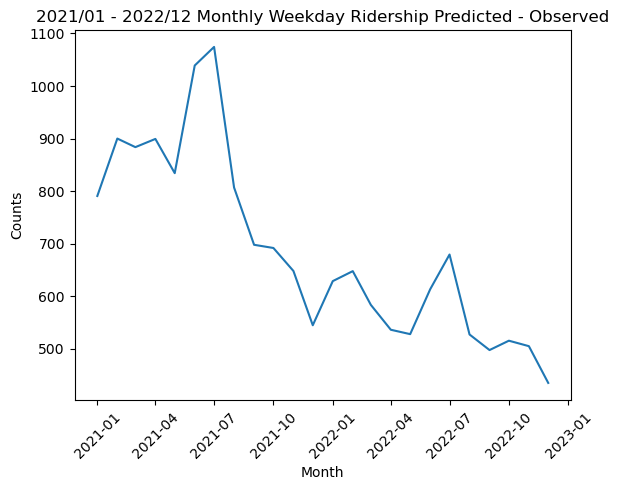

In [28]:
absolute_difference = prediction_2021_2022 - ts_2021_2022['Weekday Counts']
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("2021/01 - 2022/12 Monthly Weekday Ridership Predicted - Observed")
plt.plot(absolute_difference)
plt.savefig("figures/Berkeley_Embarcadero_2021_2022_Prediction_Observation_Difference.png")

The difference between the predicted and observed ridership is gradually decreasing, with only a 500-rider average gap expected at the end of 2022. Although the two ridership values will eventually intersect with each other, the current difference implies that Covid-19 has had a significant impact on people's choice of transportation modes. However, it is important to note that the model's training data shows a declining trend after 2015, which means the model could result in negative ridership in the future. The underlying factor that caused the drop remains unknown, but presumably it affected the model's accuracy.